In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

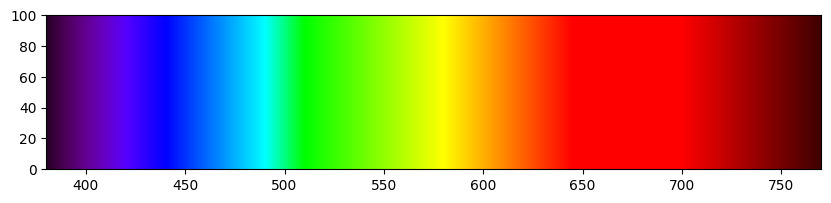

In [151]:
import numpy as np
import matplotlib.pyplot as plt

def wavelength_to_rgb(wavelength):
    """
    Convert a wavelength (or array of wavelengths) in nanometers to RGB colors.

    Parameters:
    - wavelength (float or ndarray): Wavelength(s) in nanometers (380 nm to 780 nm).

    Returns:
    - ndarray: Array of shape (..., 3) with RGB values scaled between 0 and 1.
    """
    wavelength = np.asarray(wavelength)  # Convert to NumPy array if not already

    # Initialize RGB arrays
    R = np.zeros_like(wavelength, dtype=float)
    G = np.zeros_like(wavelength, dtype=float)
    B = np.zeros_like(wavelength, dtype=float)

    # Define color mapping
    mask1 = (380 <= wavelength) & (wavelength < 440)
    R[mask1] = -(wavelength[mask1] - 440) / (440 - 380)
    B[mask1] = 1.0

    mask2 = (440 <= wavelength) & (wavelength < 490)
    G[mask2] = (wavelength[mask2] - 440) / (490 - 440)
    B[mask2] = 1.0

    mask3 = (490 <= wavelength) & (wavelength < 510)
    G[mask3] = 1.0
    B[mask3] = -(wavelength[mask3] - 510) / (510 - 490)

    mask4 = (510 <= wavelength) & (wavelength < 580)
    R[mask4] = (wavelength[mask4] - 510) / (580 - 510)
    G[mask4] = 1.0

    mask5 = (580 <= wavelength) & (wavelength < 645)
    R[mask5] = 1.0
    G[mask5] = -(wavelength[mask5] - 645) / (645 - 580)

    mask6 = (645 <= wavelength) & (wavelength <= 780)
    R[mask6] = 1.0

    # Apply intensity correction with stronger dimming at edges
    factor = np.ones_like(wavelength, dtype=float)
    mask_dim1 = (wavelength < 420)
    factor[mask_dim1] = 0.15 + 0.85 * (wavelength[mask_dim1] - 380) / (420 - 380)  # Stronger fade-in
    
    mask_dim2 = (wavelength > 700)
    factor[mask_dim2] = 0.15 + 0.85 * (780 - wavelength[mask_dim2]) / (780 - 700)  # Stronger fade-out

    # Apply factor and clip
    R = np.clip(R * factor, 0, 1)
    G = np.clip(G * factor, 0, 1)
    B = np.clip(B * factor, 0, 1)

    return np.stack([R, G, B], axis=-1)

# Generate spectrum
l = np.arange(380, 771)  # Wavelengths from 380 to 770 nm
spec = wavelength_to_rgb(l)  # Get RGB values

# Create an image (height 100, width len(l), depth 3 for RGB)
spectrum_img = np.tile(spec, (100, 1, 1))

# Display the spectrum
plt.figure(figsize=(10, 2))
plt.imshow(spectrum_img, aspect='auto', extent = [380,770,0,100])
plt.show()


In [152]:
physical_data = pd.read_csv('Wavelengths.csv')
print(physical_data)

     Element  Grating/mm  0Degree  0minute  Degree  Minute
0   Hydrogen         100       -1       -5       4      49
1   Hydrogen         100       -1       -5       3      50
2   Hydrogen         100       -1       -5       3      23
3      Argon         100       -1       -5       4      30
4      Argon         100       -1       -5       4      14
..       ...         ...      ...      ...     ...     ...
58   Mercury         300       -1       -5       8      29
59   Mercury         300       -1       -5      10      57
60  Hydrogen         600       -1       -5      23       5
61  Hydrogen         600       -1       -5      16      41
62  Hydrogen         600       -1       -5      14      42

[63 rows x 6 columns]


In [153]:
# Compute true_angle
physical_data["true_angle"] = (physical_data["Degree"] + physical_data["Minute"] / 60) + (physical_data["0Degree"] + physical_data["0minute"] / 60)

# Compute angle in decimal degrees (same as true_angle)
physical_data["angle_dec"] = physical_data["true_angle"]

# Convert angle to radians for wavelength calculation
physical_data["theta_rad"] = np.radians(physical_data["angle_dec"])

# Compute wavelength using n = Grating/mm converted to meters (1000 lines/mm → 1e3 lines/m)
physical_data["wavelength"] = np.sin(physical_data["theta_rad"])/(physical_data["Grating/mm"])*10e5

physical_data["wavelength rnd"] = np.round(physical_data["wavelength"])
# Display result
print(physical_data)

     Element  Grating/mm  0Degree  0minute  Degree  Minute  true_angle  \
0   Hydrogen         100       -1       -5       4      49    3.733333   
1   Hydrogen         100       -1       -5       3      50    2.750000   
2   Hydrogen         100       -1       -5       3      23    2.300000   
3      Argon         100       -1       -5       4      30    3.416667   
4      Argon         100       -1       -5       4      14    3.150000   
..       ...         ...      ...      ...     ...     ...         ...   
58   Mercury         300       -1       -5       8      29    7.400000   
59   Mercury         300       -1       -5      10      57    9.866667   
60  Hydrogen         600       -1       -5      23       5   22.000000   
61  Hydrogen         600       -1       -5      16      41   15.600000   
62  Hydrogen         600       -1       -5      14      42   13.616667   

    angle_dec  theta_rad  wavelength  wavelength rnd  
0    3.733333   0.065159  651.128611           651.0  
1

In [154]:
h_spectra = np.array([656, 486, 434, 410])
h_spectra_ang = np.rad2deg(np.arcsin(100*h_spectra/ (10e5)))
def dec2dms(deg):
    """
    Convert decimal degrees to degrees, minutes, and seconds (DMS).
    Handles both single inputs and arrays.

    Parameters:
        deg (float or np.ndarray): Input in decimal degrees.

    Returns:
        str or list: DMS formatted string(s).
    """
    # Ensure input is a NumPy array for vectorized operations
    deg = np.asarray(deg)

    # Calculate degrees, minutes, and seconds
    degrees = np.floor(np.abs(deg)).astype(int) * np.sign(deg)  # Handle negative values
    fractional_degrees = np.abs(deg) - np.abs(degrees)
    minutes = np.floor(fractional_degrees * 60).astype(int)
    seconds = (fractional_degrees * 3600) % 60

    # Format the output
    def format_dms(d, m, s):
        return f"{int(d)}d{int(m):02d}m{s:05.2f}s\""

    # Apply formatting to all elements if input is an array
    if deg.ndim == 0:  # Single value
        return format_dms(degrees, minutes, seconds)
    else:  # Array
        return [format_dms(d, m, s) for d, m, s in zip(degrees, minutes, seconds)]
h_spectra_ang_dms = dec2dms(h_spectra_ang)
print(h_spectra_ang_dms)

['3d45m40.69s"', '2d47m08.42s"', '2d29m14.71s"', '2d20m59.23s"']


In [155]:
# Filter the DataFrame for Hydrogen and grating 100
def element_spectra(element, grating):
    df = physical_data[(physical_data['Element'] == element) & (physical_data['Grating/mm'] == grating)]
    # Extract the rounded wavelength column
    rounded_wavelengths=df['wavelength rnd'].values
    print(rounded_wavelengths)
    return rounded_wavelengths

[651. 480. 401.]


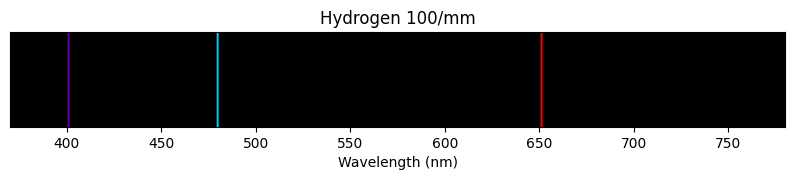

[641. 474. 399.]


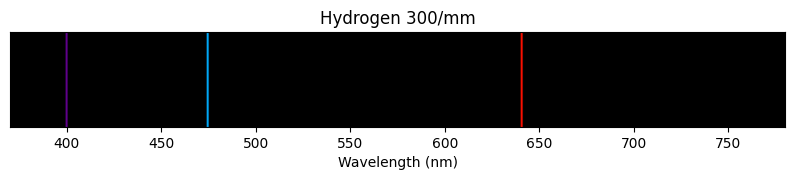

[624. 448. 392.]


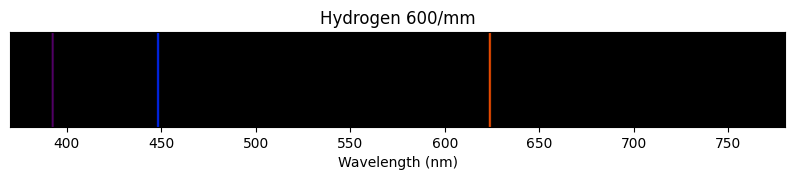

In [ ]:
def make_spectrum(title, wavelengths, height = 100):
    width = 390
    # Normalize wavelength range to fit within the 390-pixel width
    min_wl, max_wl = 370, 780
    positions = np.round((wavelengths - min_wl) / (max_wl - min_wl) * (width - 1)).astype(int)

    # Create a 100x390x3 RGB image initialized to black
    spectrum_img = np.zeros((height, width, 3))

    # Apply colors at the spectral line positions
    for pos, wl in zip(positions, wavelengths):
        color = wavelength_to_rgb(wl)
        spectrum_img[:, pos, :] = color  # Fill the column with the corresponding color

    # Display the spectrum
    plt.figure(figsize=(10, 2))
    plt.imshow(spectrum_img, extent=[min_wl, max_wl, 0, height])
    plt.xlabel("Wavelength (nm)")
    plt.yticks([])
    plt.title(title)
    plt.show()

make_spectrum("Hydrogen 100/mm", element_spectra('Hydrogen', 100), height = 50)

make_spectrum("Hydrogen 300/mm", element_spectra('Hydrogen', 300), height = 50)

make_spectrum("Hydrogen 6git 00/mm", element_spectra('Hydrogen', 600), height = 50)

[651. 480. 401.]


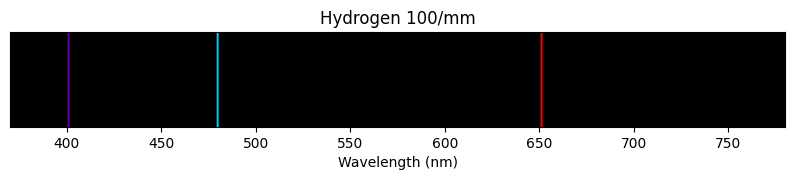

[641. 474. 399.]


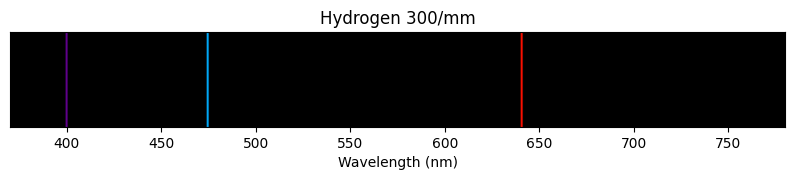

[596. 550. 506. 436. 416.]


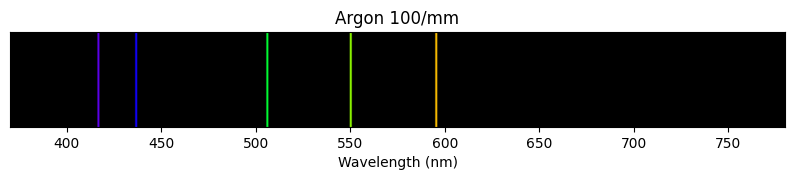

[588. 574. 546. 508. 446. 407.]


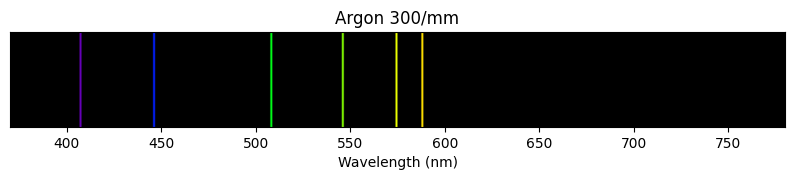

[628. 602. 541. 480. 425.]


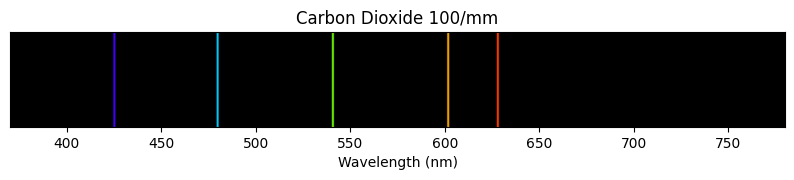

[588. 545. 508. 470. 442.]


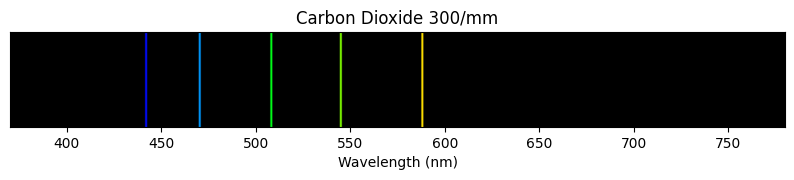

[602. 587. 538.]


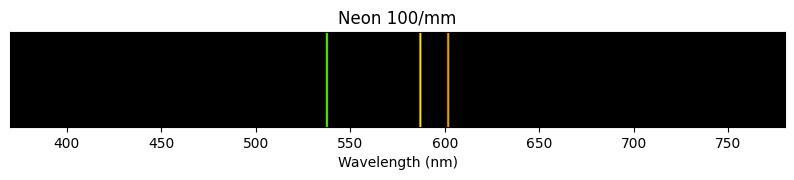

[632. 599. 574.]


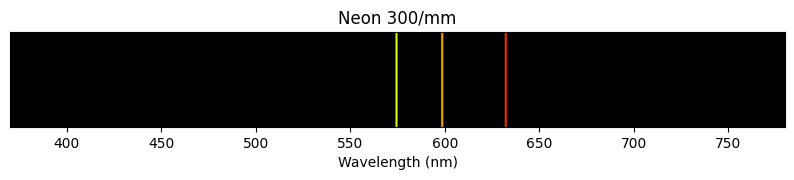

[625. 590. 642. 494. 425.]


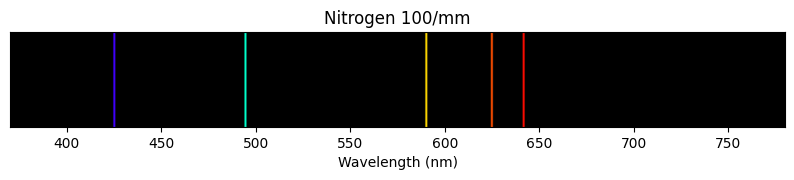

[646. 616. 486. 431.]


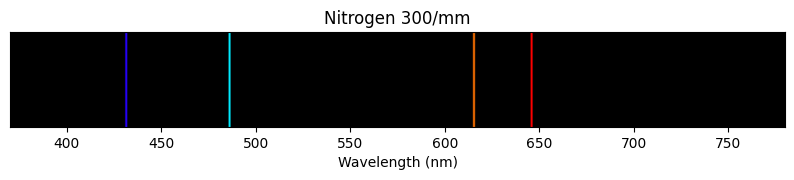

[657. 622. 581. 532. 483. 465. 427. 416.]


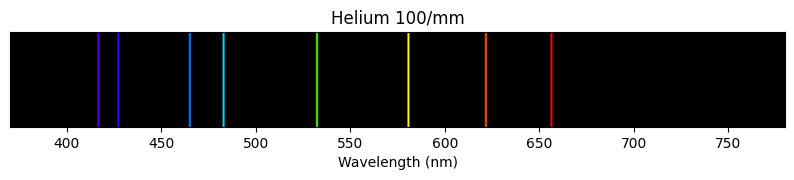

[658. 573. 486. 431.]


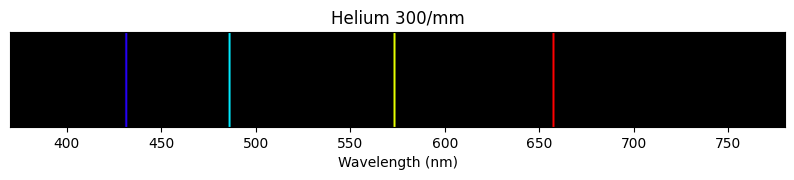

[573. 523. 425.]


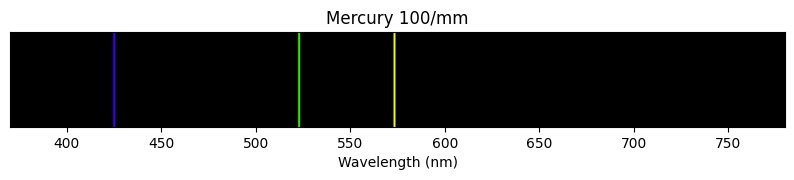

[520. 429. 571.]


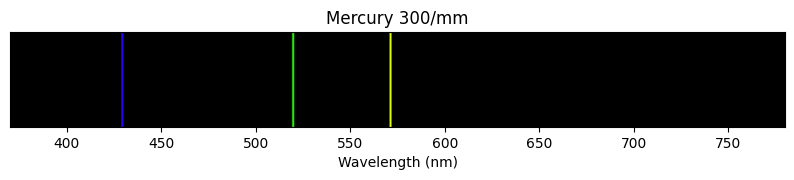

In [157]:
elements = ['Hydrogen', 'Argon', 'Carbon Dioxide', 'Neon', 'Nitrogen', 'Helium', 'Mercury']
gratings = [100,300]

for element in elements:
    for grating in gratings:
        make_spectrum(f"{element} {grating}/mm", element_spectra(element, grating), height = 50)


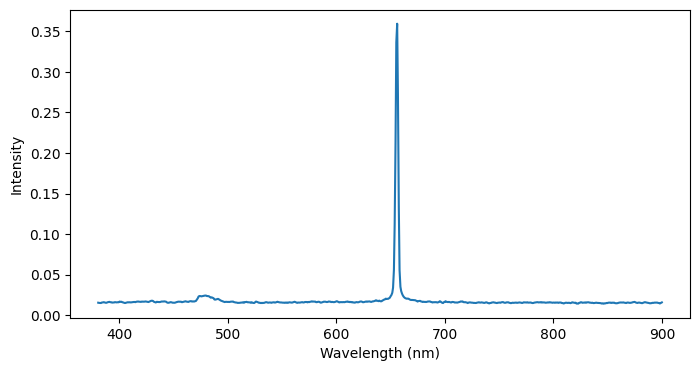

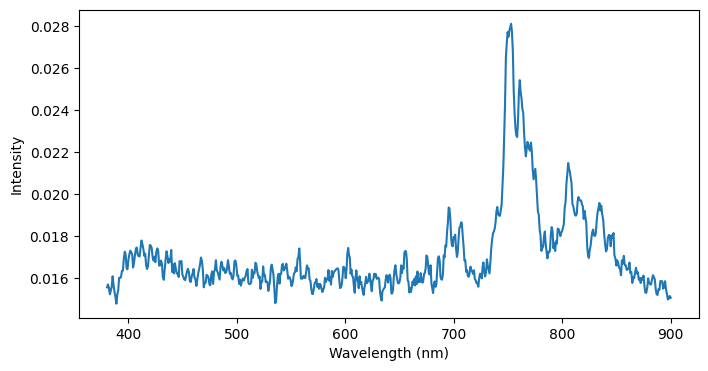

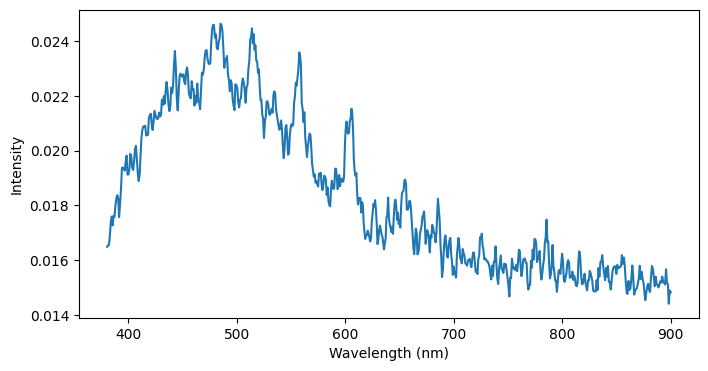

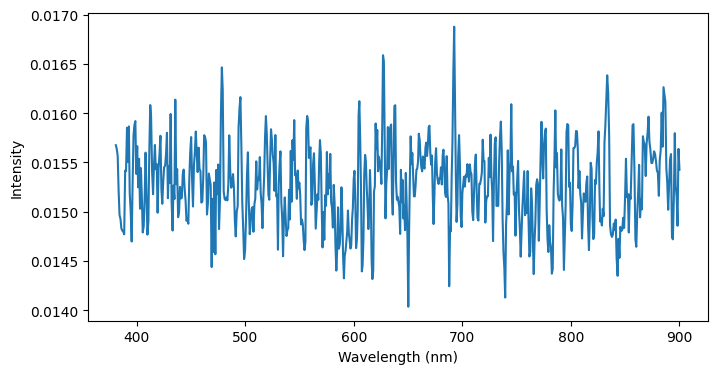

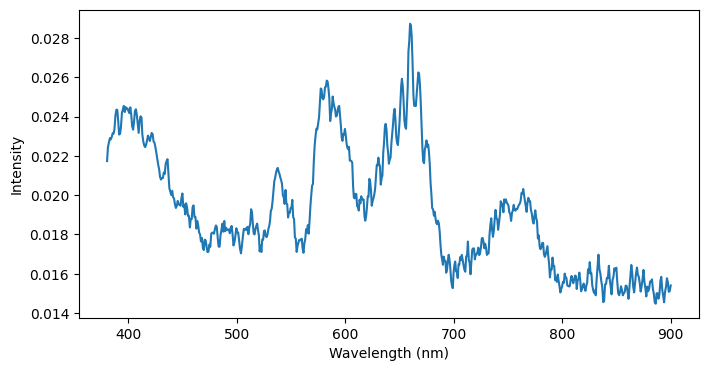

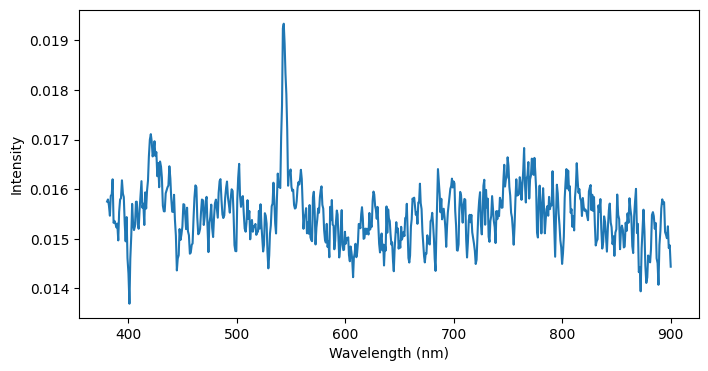

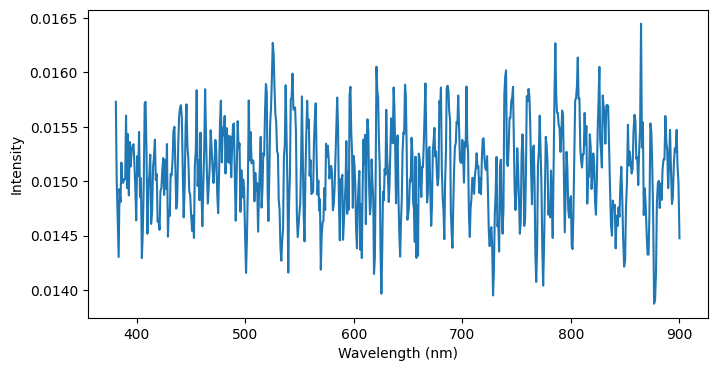

In [158]:
H_df = pd.read_csv('HYDROGEN.csv')
Ar_df = pd.read_csv('ARGON.csv')
CO2_df = pd.read_csv('CO2.csv')
He_df = pd.read_csv('HELIUM.csv')
Ne_df = pd.read_csv('NEON.csv')
N_df = pd.read_csv('NITROGEN.csv')
Hg_df = pd.read_csv('MERCURY.csv')
ambient_df = pd.read_csv('AMBIENT.csv')
def plot_spectra(df):
    x = df['Data Set 1:Wavelength(nm)']
    y = df['Data Set 1:Intensity']
    plt.figure(figsize=(8,4))
    plt.plot(x,y)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
plot_spectra(H_df)
plot_spectra(Ar_df)
plot_spectra(CO2_df)
plot_spectra(He_df)
plot_spectra(N_df)
plot_spectra(Hg_df)
plot_spectra(ambient_df)